### Logistci Regression using Pytorch - CIFAR10 ###
1.Iswariya Manivannan<br>
2.Sathiya Ramesh

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.utils.data as utils_data
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

torch.manual_seed(40)
torch.cuda.manual_seed(40)
np.random.seed(2)

In [11]:
# Normalizing the output PIL Image of Torchvision dataset from [0,1] to [-1,1]
transform = transforms.Compose([transforms.ColorJitter(brightness= 5, contrast= 5),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Implementation of Validation split using SubsetRandomSampler in Pytorch

train_set_size = int(0.8 * len(trainset))    # Train set - Val set split is 80% - 20%
train_indices = np.random.choice(np.arange(len(trainset)), train_set_size, replace = False)  # Getting the random 80% of train data from train set
train_sampler = SubsetRandomSampler(train_indices)

# Getting the 20% val data not present in train indices
val_indices = np.setdiff1d(np.arange(len(trainset)), train_indices, assume_unique= True)
val_sampler = SubsetRandomSampler(val_indices)
#print(np.any(np.isin(train_indices, val_indices)))

In [13]:
batch_size = 512
learning_rate = 0.0001

num_epochs = 50

trainloader = utils_data.DataLoader(trainset, batch_size = batch_size, sampler=train_sampler, num_workers=2)
valloader = utils_data.DataLoader(trainset, batch_size = batch_size, sampler=val_sampler, num_workers=2)
testloader = utils_data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)


In [5]:
# 2 layer Logistic Regression Model which has one Hidden layer with Relu activation and an Output layer
class LogisticRegression_model(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(LogisticRegression_model, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, 1024)
        self.linear2 = nn.Linear(1024, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x


In [6]:
# Function to calculate test accuracy
def Test(dataloader):
    model.eval()
    correct_pred = 0
    total = 0
    total_loss = 0
    prediction_array = np.array([])
    labels_array = np.array([])
    iter = 0
    for images, labels in dataloader:
        
        if torch.cuda.is_available():
            
            test_images = Variable(images.view(-1, 32*32*3).cuda())
            labels = Variable(labels.cuda())
        else:
            test_images = Variable(images.view(-1, 32*32*3))
            labels = Variable(labels)
         
        # Getting the model predictions
        y_pred = model(test_images)
        loss = criterion(y_pred, labels)
        total_loss += loss.data[0]
        _, pred_class = torch.max(y_pred.data, 1)

        # Storing predictions and true labels in numpy arrays for printing confusion matrix
        prediction_array = np.append(prediction_array, pred_class.cpu().numpy(), axis =0)
        labels_array = np.append(labels_array, labels.data.cpu().numpy(), axis = 0)
        iter +=1
        correct_pred += (pred_class.cpu() == labels.data.cpu()).sum()
        total += labels.size(0)
        

    accuracy = 100. * (correct_pred.numpy()/total)
                                   
    return total_loss/len(dataloader), accuracy, prediction_array, labels_array

In [7]:
# Function to train the Model
def Train(trainloader):
    model.train()
    correct_pred = 0
    total_no_labels = 0
    total_train_loss = 0
    iter = 0
    
    for i, (images, labels) in enumerate(trainloader):

        # Feeding data to GPU 

        if torch.cuda.is_available():
            train_images = Variable(images.view(-1, 3*32*32).cuda())
            train_labels = Variable(labels.cuda())
        else:
            train_images = Variable(images.view(-1, 3*32*32))
            train_labels = Variable(labels)
       
        #Forward
        y_pred = model(train_images)
        
        #Loss Function
        loss = criterion(y_pred, train_labels)
        total_train_loss += loss.data[0]
        
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        iter +=1
        #Update weights
        optimizer.step()
        
        
        # Finding the number of correct predictions in the training set
        _, pred_class = torch.max(y_pred.data, 1)

        correct_pred += (pred_class.cpu() == train_labels.data.cpu()).sum()
        total_no_labels += labels.size(0)

    train_acc = 100. * (correct_pred.numpy()/total_no_labels)
    return total_train_loss/len(trainloader), train_acc
    


In [8]:

input_dim = 32*32*3
output_dim = 10


train_loss_values =[]
train_acc_values =[]

test_loss_values =[]
test_acc_values =[]

val_loss_values =[]
val_acc_values =[]


# Instatiating the LogisticRegression_model
model = LogisticRegression_model(input_dim, output_dim)

# Feeding model to GPU
if torch.cuda.is_available():
    model.cuda()

# Using Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Feeding loss function to GPU
if torch.cuda.is_available():
    criterion = criterion.cuda()

#Using Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

for epoch in range(num_epochs):

    train_loss, train_acc = Train(trainloader)  # Training set accuracy
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    val_loss, val_acc = Test(valloader)[0:2] # Validation set loss & accuracy
    val_loss_values.append(val_loss)
    val_acc_values.append(val_acc)

    test_loss, test_acc, Predicted_labels, True_labels = Test(testloader) # Test set accuracy
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch}   Train Loss: {train_loss.cpu().numpy():.5f}   Train Acc:{train_acc:.5f}%\
    Val Loss: {val_loss.cpu().numpy():.5f}  Val Acc:{val_acc:.5f}%   Test Acc: {test_acc:.5f}% ')

    

/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0   Train Loss: 1.81167   Train Acc:36.88500%    Val Loss: 1.66190  Val Acc:41.87000%   Test Acc: 42.96000% 
Epoch: 1   Train Loss: 1.60420   Train Acc:44.62250%    Val Loss: 1.56955  Val Acc:45.75000%   Test Acc: 45.99000% 


Process Process-13:
Process Process-14:
Traceback (most recent call last):
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/cifar.py", line 121, in __getitem__
    img = self.transform(img)
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/pyt

Traceback (most recent call last):
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-7920dc701e0e>", line 35, in <module>
    train_loss, train_acc = Train(trainloader)  # Training set accuracy
  File "<ipython-input-7-7080dd709161>", line 9, in Train
    for i, (images, labels) in enumerate(trainloader):
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/home/iswariya/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/iswariya/anaconda3/envs/tensorflow/

KeyboardInterrupt: 

In [10]:
print(model.op)

[{'params': [Parameter containing:
tensor([[-3.2008e-03,  1.4973e-02, -1.0127e-02,  ...,  1.2930e-03,
          1.4190e-02, -5.0433e-03],
        [ 1.2765e-02,  7.7512e-03, -1.3806e-02,  ...,  2.3576e-02,
          1.5741e-02, -6.9928e-04],
        [ 5.3717e-03, -7.5089e-03, -1.3443e-02,  ...,  9.8624e-03,
         -2.3753e-03, -1.1969e-02],
        ...,
        [-1.5127e-02, -1.3200e-02,  5.5072e-03,  ..., -1.0492e-02,
          1.5228e-02, -3.3382e-03],
        [-1.7845e-02,  6.4983e-03, -1.4670e-02,  ..., -1.2418e-02,
         -8.0281e-03,  2.3327e-03],
        [ 1.0255e-03,  1.1680e-02,  1.5241e-02,  ...,  1.4835e-02,
          8.5263e-03,  1.4718e-03]], device='cuda:0'), Parameter containing:
tensor(1.00000e-02 *
       [ 1.3495, -0.3641, -1.3298,  ..., -1.1527,  0.9946, -0.7003], device='cuda:0'), Parameter containing:
tensor(1.00000e-02 *
       [[ 2.5349, -3.6530,  1.4334,  ..., -1.6639,  2.6405,  2.5944],
        [ 3.5170,  1.8205,  2.0998,  ...,  1.4811, -3.3034,  1.0580],
  

In [10]:
torch.save(model.state_dict(), "logistic_reg_model.th")


Text(0,0.5,'Percentage Accuracy')

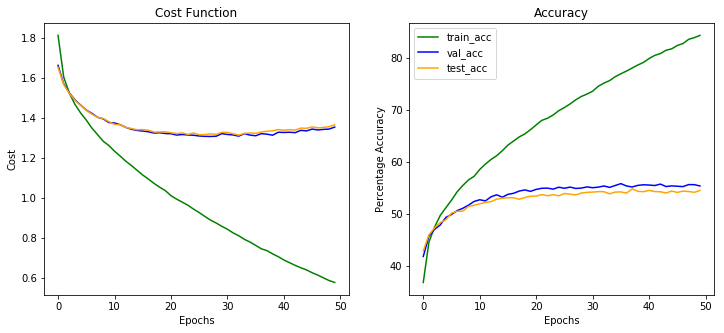

In [9]:
#Plotting the cost function
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.set_title("Cost Function")
ax.plot(train_loss_values, '-', color='green')
ax.plot(val_loss_values, '-', color='blue')
ax.plot(test_loss_values, '-', color='orange')
ax.set_xlabel("Epochs")
ax.set_ylabel("Cost")
#ax.set_yscale('log')

ax1 = fig.add_subplot(1,2,2)
ax1.set_title("Accuracy")
ax1.plot(train_acc_values, '-', color='green')
ax1.plot(val_acc_values, '-', color='blue')
ax1.plot(test_acc_values, '-', color='orange')
ax1.legend(['train_acc', 'val_acc', 'test_acc'],loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Percentage Accuracy")

In [29]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(True_labels, Predicted_labels)
print(cm)

[[639  25  63  19  29  16  26  31  91  61]
 [ 41 589  23  21  15  11  16  25  66 193]
 [ 82  12 450  67 137  89  62  64  19  18]
 [ 31  18  95 344  83 199  90  73  22  45]
 [ 40   7 118  59 495  63  76  94  23  25]
 [ 22   5  79 181  85 474  42  59  24  29]
 [ 14  18  86  79 116  53 576  19  13  26]
 [ 38   9  51  55  86  81  17 615   9  39]
 [117  67  21  19  17  22   4  15 647  71]
 [ 45 136  17  25  20  22  21  50  39 625]]


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


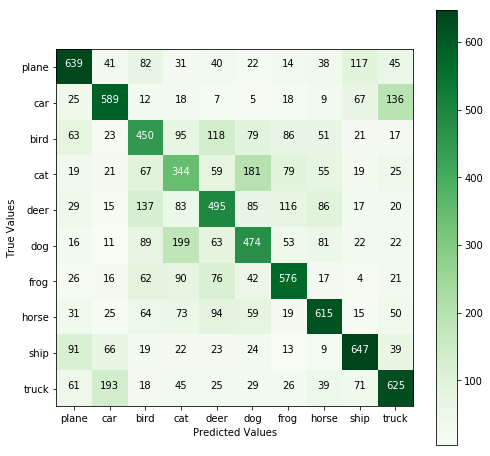

In [30]:
# Plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes):
    
    cmap = plt.get_cmap('Greens')
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap = cmap, interpolation = 'nearest')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    print(classes)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    threshold = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(i, j, f'{cm[i, j]}' , horizontalalignment = 'center', 
                 color="white" if cm[i, j] > threshold else "black")

plot_confusion_matrix(cm, classes)